In [1]:
# standard libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow import keras

# scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pd.set_option('display.max_columns', None)

# Set custom styles for text color
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'  # Color of the x-axis tick values
plt.rcParams['ytick.color'] = 'white'  # Color of the y-axis tick values

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

2023-09-26 20:33:06.466339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [6]:
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [7]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [8]:
target = train.columns.to_list()[-1]
# convert target from bool to int
train[target] = train[target].astype(int)
train_target = train[target]

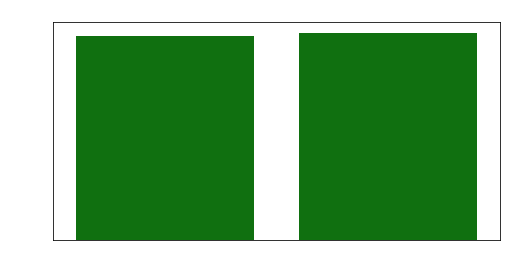

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(data = train, x = target, color='g')
plt.title('Class distribution')
plt.show()

In [10]:
train.drop(target, axis=1, inplace=True)
train_id = train['PassengerId']
test_id = test['PassengerId']

In [11]:
# combine over rows, keeping id for now as group number might be useful
combined = pd.concat([train, test], axis = 0)

### Feature engineering

In [12]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.4+ MB


In [13]:
combined.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [14]:
combined['Group'] = combined['PassengerId'].str[:4]
combined.drop('PassengerId', inplace=True, axis=1)

Categorical columns

In [15]:
# categorical columns
col_cat_NA = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

# fill with Group first
for col in col_cat_NA:
    combined[col] = combined.groupby('Group')[col].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
# need to do this, so we can use homeplanet to fill values for destination
combined['HomePlanet'].fillna('', inplace=True)
combined['Destination'] = combined.groupby('HomePlanet')['Destination'].transform(
    lambda x: x.fillna(x.mode()[0]))
# reverse what we did earlier
combined['HomePlanet'].replace('', np.nan, inplace=True)

# now fill homeplanet with destination
combined['HomePlanet'] = combined.groupby('Destination')['HomePlanet'].transform(
    lambda x: x.fillna(x.mode()[0]))

combined['CryoSleep'] = combined.groupby('Destination')['CryoSleep'].transform(
    lambda x: x.fillna(x.mode()[0]))
combined['VIP'].fillna(False, inplace=True)
    
# need to break cabin down, this is screwing it up when the entire cabin isn't available
combined[['deck', 'cabin_num', 'side']] = combined['Cabin'].str.split('/', expand=True)

combined.drop('Cabin', inplace=True, axis=1)

col_cat_na = ['deck', 'cabin_num', 'side']

for col in col_cat_na:
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.mode()[0]))
combined['cabin_num'] = combined['cabin_num'].astype(int)

# drop name
combined.drop('Name', inplace=True, axis=1)

Numerical columns

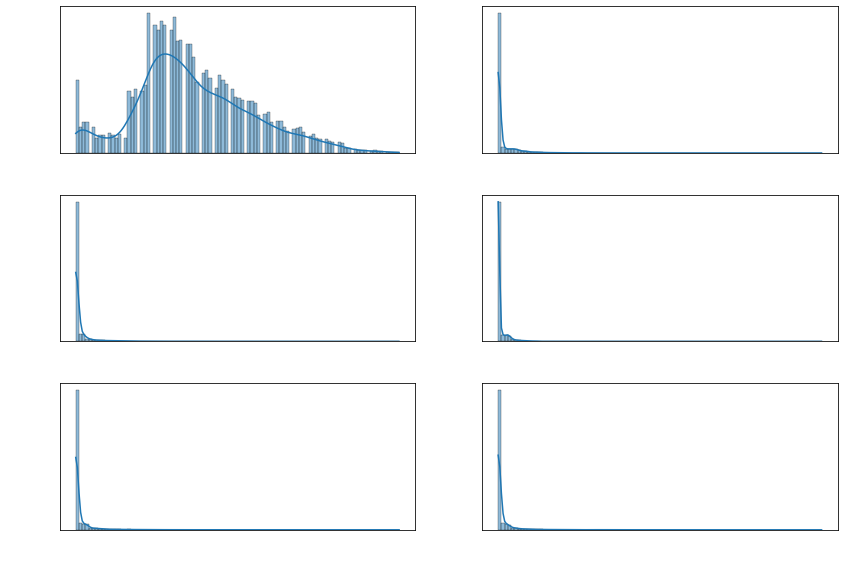

In [17]:
# numerical columns 
col_num = combined.select_dtypes(include=['number']).columns
col_num = col_num.drop(['cabin_num', 'CryoSleep'])

# subplot placehodlers
fig, axes = plt.subplots(3, 2, figsize=(12,8))

# flatten the axes for easier indexing
axes = axes.ravel()

# iterate over number columns, enumerate cause working with index list
for i, col in enumerate(col_num):
    ax = axes[i]
    # checking distribution for data above 0
    t = combined.loc[combined[col]>-1]
    sns.histplot(t[col], ax=ax, kde=True, bins=100)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    
# adjust layout
plt.tight_layout()

plt.show()

In [20]:
display(combined.loc[combined['RoomService']>0].describe())
display(combined.loc[combined['RoomService']>0].median())

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_num
count,4404.000000,4321.000000,4404.000000,4296.000000,4303.000000,4304.000000,4322.000000,4404.000000
mean,0.004087,31.032631,643.134196,484.818203,313.019986,365.609433,337.559695,645.533606
std,0.063808,12.431650,969.486624,1477.621759,657.312688,1118.498526,1187.149866,536.059777
min,0.000000,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,37.000000,0.000000,0.000000,0.000000,0.000000,193.000000
50%,0.000000,28.000000,313.500000,2.000000,19.000000,6.000000,1.000000,471.000000
75%,0.000000,38.000000,857.000000,276.000000,372.000000,245.000000,171.000000,1070.250000
max,1.000000,79.000000,14327.000000,26830.000000,8098.000000,22408.000000,24133.000000,1894.000000


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_23215/3600371989.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(combined.loc[combined['RoomService']>0].median())


CryoSleep          0.0
Age               28.0
VIP                0.0
RoomService      313.5
FoodCourt          2.0
ShoppingMall      19.0
Spa                6.0
VRDeck             1.0
Group           4639.5
cabin_num        471.0
dtype: float64

In [21]:
# replace 0s with null
combined[col_num] = combined[col_num].replace(0, np.nan)

# fill with Group first
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Group')[col].transform(
        lambda x: x.fillna(x.mean()))

In [22]:
# fill with destination now
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.median()))

In [23]:
# take log due to skewed distribution
for i, col in enumerate(col_num):
    combined[col] = np.log1p(combined[col])

In [24]:
# adding new features
combined['TotalSpent'] = combined[['RoomService', 'FoodCourt', 
                                   'ShoppingMall','Spa', 'VRDeck']].sum(axis=1)

# since the distribution is so skewed to 0s, this might help
# combined['moneySpent'] = (combined['TotalSpent']>0).astype(int)

In [25]:
combined['VIP'].unique()

array([0.0, 1.0], dtype=object)

<Figure size 864x576 with 0 Axes>

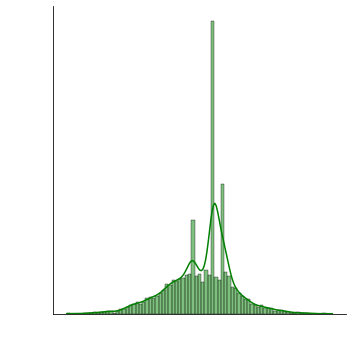

In [26]:
col = 'TotalSpent'
plt.figure(figsize=(12,8))
sns.displot(data=combined, x=col, color='g', kde=True)
plt.show()

In [27]:
col_bool = ['CryoSleep', 'VIP']

# correct dtypes of boolean columns from object to bool then to int
for col in col_bool:
    combined[col] = combined[col].astype(bool).astype(int)

In [28]:
# convert category columns to numerical/binary
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  int64  
 2   Destination   12970 non-null  object 
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  int64  
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  Group         12970 non-null  object 
 11  deck          12970 non-null  object 
 12  cabin_num     12970 non-null  int64  
 13  side          12970 non-null  object 
 14  TotalSpent    12970 non-null  float64
dtypes: float64(7), int64(3), object(5)
memory usage: 1.6+ MB


In [29]:
# one hot encoding
combined = pd.get_dummies(combined, columns=['HomePlanet', 'Destination', 'deck', 'side'])

# shouldn't be, but for now, let's...maybe this does make sense after all
combined['Group'] = combined['Group'].astype('int')

In [30]:
# change dtypes to int
combined.iloc[:, -16:] = combined.iloc[:, -16:].astype(int)

In [31]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  12970 non-null  int64  
 1   Age                        12970 non-null  float64
 2   VIP                        12970 non-null  int64  
 3   RoomService                12970 non-null  float64
 4   FoodCourt                  12970 non-null  float64
 5   ShoppingMall               12970 non-null  float64
 6   Spa                        12970 non-null  float64
 7   VRDeck                     12970 non-null  float64
 8   Group                      12970 non-null  int64  
 9   cabin_num                  12970 non-null  int64  
 10  TotalSpent                 12970 non-null  float64
 11  HomePlanet_Earth           12970 non-null  int64  
 12  HomePlanet_Europa          12970 non-null  int64  
 13  HomePlanet_Mars            12970 non-null  int6

In [32]:
# saving a combined copy
combinedCopy = combined.copy(deep=True)

In [33]:
combined = combinedCopy.copy(deep=True)

Min-max Normalization

In [34]:
def min_max_norm(col):
    min_val = col.min()
    max_val = col.max()
    
    return (col-min_val) / (max_val - min_val)

combined = combined.apply(min_max_norm)

### Model design

In [35]:
train = combined.iloc[:train_id.shape[0]]
test = combined.iloc[-test_id.shape[0]:]
train[target] = train_target
print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (8693, 28)
Test shape (4277, 27)


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_23215/2658725243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[target] = train_target


In [36]:
# let's split train data into train/test
def train_test_split(data, test_ratio=0.3):
    test_indices = np.random.rand(data.shape[0]) < test_ratio
    return data[~test_indices], data[test_indices]
train_data, test_data = train_test_split(train)
print('{} samples in training, {} samples in testing data'.format(train_data.shape[0], 
                                                            test_data.shape[0]))

6076 samples in training, 2617 samples in testing data


In [37]:
train_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,cabin_num,TotalSpent,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S,Transported
0,0.0,0.812098,0.0,0.590200,0.539814,0.501582,0.514345,0.505796,0.000000,0.000000,0.554966,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.0,0.580140,0.0,0.565955,0.371455,0.462127,0.605470,0.043143,0.000323,0.000528,0.350739,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
5,0.0,0.844027,0.0,0.515354,0.571194,0.490608,0.534488,0.513321,0.000431,0.000000,0.547546,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
6,0.0,0.705550,0.0,0.345625,0.691642,0.073965,0.514345,0.505796,0.000539,0.001056,0.385912,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
7,1.0,0.724922,0.0,0.345625,0.691642,0.073965,0.514345,0.505796,0.000539,0.000000,0.385912,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8686,0.0,0.759949,0.0,0.000000,0.660981,0.501582,0.347346,0.304547,0.999461,0.051214,0.285475,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8687,0.0,0.743001,0.0,0.000000,0.768042,0.501582,0.043486,0.543610,0.999461,0.051214,0.301321,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
8688,0.0,0.825324,1.0,0.535506,0.846495,0.461422,0.719829,0.385641,0.999569,0.051742,0.657842,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8689,1.0,0.610292,0.0,0.515354,0.452702,0.490608,0.433614,0.513321,0.999784,0.791447,0.473066,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6076 entries, 0 to 8690
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  6076 non-null   float64
 1   Age                        6076 non-null   float64
 2   VIP                        6076 non-null   float64
 3   RoomService                6076 non-null   float64
 4   FoodCourt                  6076 non-null   float64
 5   ShoppingMall               6076 non-null   float64
 6   Spa                        6076 non-null   float64
 7   VRDeck                     6076 non-null   float64
 8   Group                      6076 non-null   float64
 9   cabin_num                  6076 non-null   float64
 10  TotalSpent                 6076 non-null   float64
 11  HomePlanet_Earth           6076 non-null   float64
 12  HomePlanet_Europa          6076 non-null   float64
 13  HomePlanet_Mars            6076 non-null   float

Model: Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=10000)
lr.fit(train_data.iloc[:, :-1], train_data[target])

In [ ]:
prediction = lr.predict(test_data.iloc[:, :-1])

In [ ]:
accuracy = accuracy_score(test_data[target], prediction)
print('Accuracy of {}'.format(accuracy))

Model: SVM (takes a while to run this though)

In [ ]:
# param_grid = {
#     'C': [0.1, 1, 10], # regularization parameter
#     'kernel': ['linear', 'rbf'], # kernel type
#     'gamma': [0.1, 1, 10] # kernel coefficient
# }

# svm = SVC()
# grid_search = GridSearchCV(svm, param_grid, cv=5)
# grid_search.fit(train_data.iloc[:, :-1], train_data[target])

# grid_search.best_params_

Model: TFDF

In [ ]:
# convert these to tensorflow datasets
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=target)
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=target)

In [ ]:
rf = tfdf.keras.RandomForestModel()
rf.fit(train_data)

In [ ]:
rf.summary()

In [ ]:
rf.compile(metrics=['accuracy'])
evaluation = rf.evaluate(test_data, return_dict=True)
display(evaluation)

In [ ]:
# tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

Prediction

In [ ]:
test = tfdf.keras.pd_dataframe_to_tf_dataset(test)
predictions = rf.predict(test)
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
# convert to boolean
output[target] = (output[target] >= 0.5)

In [ ]:
output.info()

In [ ]:
output.to_csv('data/sample_submission.csv', index=False)

Model : FNN  
Feedforwrad Neural Network

In [43]:
# can optimize following two
layer_size = 8
neuron_size = 64

layer_activation = 'relu'
output_activation = 'sigmoid'

# based on data
feature_size = train_data.shape[1]-1 # -1 cause target column
target_class_count = len(train_data[target].unique())-1 # cause binary, 0 doesn't count

model = keras.Sequential([
    keras.layers.Dense(layer_size, activation=layer_activation, 
                      input_shape=(feature_size,)),
    keras.layers.Dense(neuron_size, activation=layer_activation),
    keras.layers.Dense(target_class_count, activation=output_activation)
])

# optimizer options: SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Ftrl
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='binary_crossentropy',
             metrics=['accuracy'])

In [44]:
epoch_size = 200
batch_size = 32
history = model.fit(train_data.drop(columns=target), train_data[target], 
                    epochs = epoch_size, batch_size=batch_size,
                    validation_data=(test_data.drop(columns=target), test_data[target]))

Epoch 1/200
190/190 [==============================] - 1s 2ms/step - loss: 0.6887 - accuracy: 0.5792 - val_loss: 0.6836 - val_accuracy: 0.6118
Epoch 2/200
190/190 [==============================] - 0s 1ms/step - loss: 0.6803 - accuracy: 0.6205 - val_loss: 0.6731 - val_accuracy: 0.6576
Epoch 3/200
190/190 [==============================] - 0s 2ms/step - loss: 0.6686 - accuracy: 0.6539 - val_loss: 0.6569 - val_accuracy: 0.6855
Epoch 4/200
190/190 [==============================] - 0s 2ms/step - loss: 0.6500 - accuracy: 0.6809 - val_loss: 0.6342 - val_accuracy: 0.7065
Epoch 5/200
190/190 [==============================] - 0s 2ms/step - loss: 0.6261 - accuracy: 0.6955 - val_loss: 0.6088 - val_accuracy: 0.7142
Epoch 6/200
190/190 [==============================] - 0s 2ms/step - loss: 0.6021 - accuracy: 0.7026 - val_loss: 0.5853 - val_accuracy: 0.7214
Epoch 7/200
190/190 [==============================] - 0s 2ms/step - loss: 0.5816 - accuracy: 0.7093 - val_loss: 0.5674 - val_accuracy: 0.7310

Epoch 58/200
190/190 [==============================] - 0s 2ms/step - loss: 0.4876 - accuracy: 0.7485 - val_loss: 0.4975 - val_accuracy: 0.7532
Epoch 59/200
190/190 [==============================] - 0s 2ms/step - loss: 0.4867 - accuracy: 0.7497 - val_loss: 0.5003 - val_accuracy: 0.7512
Epoch 60/200
190/190 [==============================] - 0s 2ms/step - loss: 0.4872 - accuracy: 0.7493 - val_loss: 0.4978 - val_accuracy: 0.7547
Epoch 61/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4867 - accuracy: 0.7505 - val_loss: 0.4971 - val_accuracy: 0.7543
Epoch 62/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4864 - accuracy: 0.7490 - val_loss: 0.4996 - val_accuracy: 0.7512
Epoch 63/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4858 - accuracy: 0.7498 - val_loss: 0.4967 - val_accuracy: 0.7512
Epoch 64/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4863 - accuracy: 0.7515 - val_loss: 0.4968 - val_accuracy:

Epoch 115/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4793 - accuracy: 0.7556 - val_loss: 0.4914 - val_accuracy: 0.7535
Epoch 116/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4791 - accuracy: 0.7538 - val_loss: 0.4937 - val_accuracy: 0.7558
Epoch 117/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4791 - accuracy: 0.7576 - val_loss: 0.4917 - val_accuracy: 0.7516
Epoch 118/200
190/190 [==============================] - 0s 2ms/step - loss: 0.4792 - accuracy: 0.7531 - val_loss: 0.4914 - val_accuracy: 0.7532
Epoch 119/200
190/190 [==============================] - 0s 2ms/step - loss: 0.4791 - accuracy: 0.7538 - val_loss: 0.4921 - val_accuracy: 0.7562
Epoch 120/200
190/190 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.7556 - val_loss: 0.4919 - val_accuracy: 0.7524
Epoch 121/200
190/190 [==============================] - 0s 2ms/step - loss: 0.4785 - accuracy: 0.7561 - val_loss: 0.4916 - val_ac

190/190 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.7571 - val_loss: 0.4886 - val_accuracy: 0.7551
Epoch 172/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4723 - accuracy: 0.7586 - val_loss: 0.4903 - val_accuracy: 0.7574
Epoch 173/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4729 - accuracy: 0.7597 - val_loss: 0.4882 - val_accuracy: 0.7528
Epoch 174/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4730 - accuracy: 0.7581 - val_loss: 0.4887 - val_accuracy: 0.7478
Epoch 175/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4730 - accuracy: 0.7591 - val_loss: 0.4879 - val_accuracy: 0.7539
Epoch 176/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4724 - accuracy: 0.7604 - val_loss: 0.4880 - val_accuracy: 0.7535
Epoch 177/200
190/190 [==============================] - 0s 1ms/step - loss: 0.4724 - accuracy: 0.7594 - val_loss: 0.4885 - val_accuracy: 0.7554

In [41]:
history_df = pd.DataFrame()

history_df['epoch_round'] = [num+1 for num in range(epoch_size)]
history_df['training_loss'] = history.history['loss']
history_df['training_accuracy'] = history.history['accuracy']
history_df['val_loss'] = history.history['val_loss']
history_df['val_accuracy'] = history.history['val_accuracy']

# helps get rid of the initial outliers for visuals
history_df = history_df.loc[history_df['epoch_round']>5]

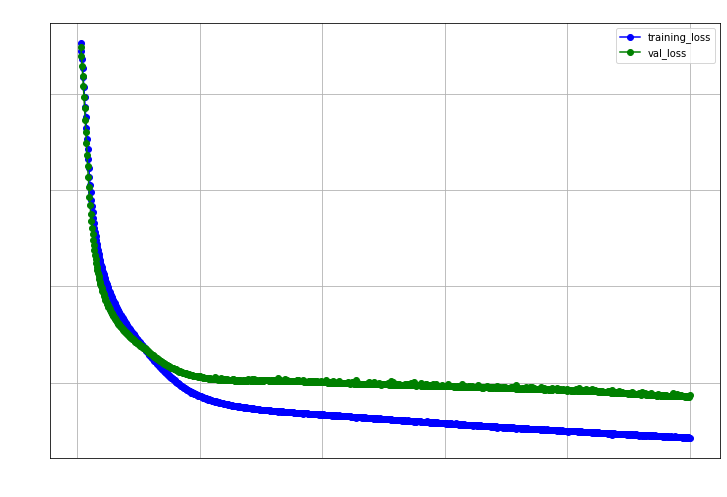

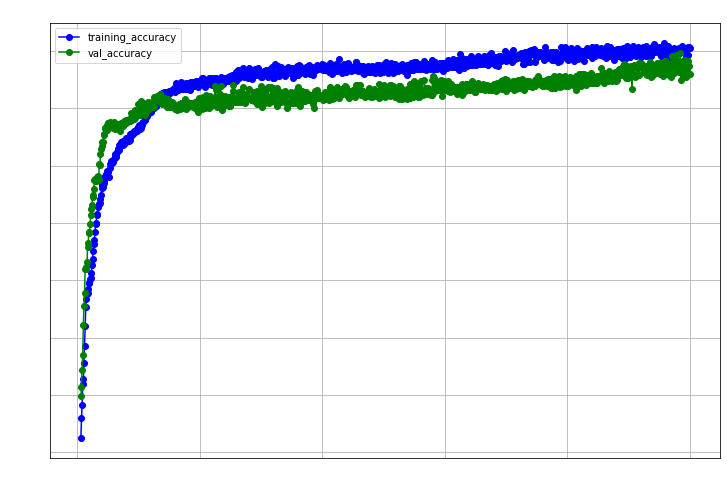

In [42]:
plt.figure(figsize=(12,8))
plt.grid(True)

plt.plot(history_df['epoch_round'], history_df['training_loss'], marker='o',
        linestyle='-', color='blue', label='training_loss')
plt.plot(history_df['epoch_round'], history_df['val_loss'], marker='o',
        linestyle='-', color='green', label='val_loss')

plt.xlabel('epoch_round')
plt.ylabel('loss')
plt.title('Loss visualized')

legend = plt.legend()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color('black')
    
plt.show()

plt.figure(figsize=(12,8))
plt.grid(True)

plt.plot(history_df['epoch_round'], history_df['training_accuracy'], marker='o',
        linestyle='-', color='blue', label='training_accuracy')
plt.plot(history_df['epoch_round'], history_df['val_accuracy'], marker='o',
        linestyle='-', color='green', label='val_accuracy')

plt.xlabel('epoch_round')
plt.ylabel('accuracy')
plt.title('Accuracy visualized')

legend = plt.legend()

# Set the legend text color to white
for text in legend.get_texts():
    text.set_color('black')
    
plt.show()